**Objective**

To forecast the COVID-19 cumulative confirmed cases for 60 days into the future using traditional method ARIMA

**Description of the Data**

The data is obatined from [John Hopkins COVID-19 database](https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases)

**Features**
Country/Region: Country or Continent
Province: District or state in the country.
Lat : Latitude 
Long: Longitude

Date: Contains cumulative reported corfirmed cases of COVID-19.

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5 MB 8.2 MB/s 
     |████████████████████████████████| 9.5 MB 57.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [25]:
#Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import itertools
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
# Visualization libraries.
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline
import seaborn as sns
import folium
from matplotlib.ticker import FixedFormatter
import matplotlib
from folium import plugins
# Warnings 
import warnings
warnings.filterwarnings("ignore")

In [26]:
Confirmed = pd.read_csv("time_series_covid19_confirmed_global.csv")

# Exploratory Data Analysis

In [27]:
data = Confirmed.copy()
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/7/21,6/8/21,6/9/21,6/10/21,6/11/21,6/12/21,6/13/21,6/14/21,6/15/21,6/16/21,6/17/21,6/18/21,6/19/21,6/20/21,6/21/21,6/22/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,63355,63412,63484,63598,63819,64122,64575,65080,65486,65728,66275,66903,67743,68366,69130,70111,70761,71838,72977,74026,75119,76628,77963,79224,80841,82326,84050,85892,87716,88740,89861,91458,93272,93288,96531,98734,98734,98734,103902,105749
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,131939,131978,132015,132032,132071,132095,132118,132153,132176,132209,132215,132229,132244,132264,132285,132297,132309,132315,132337,132351,132360,132372,132374,132379,132384,132397,132415,132426,132437,132449,132459,132461,132469,132476,132481,132484,132488,132490,132490,132496
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,125059,125194,125311,125485,125693,125896,126156,126434,126651,126860,127107,127361,127646,127926,128198,128456,128725,128913,129218,129640,129976,130361,130681,130958,131283,131647,132034,132355,132727,133070,133388,133742,134115,134458,134840,135219,135586,135821,136294,136679
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,13510,13510,13510,13555,13569,13569,13569,13569,13569,13569,13569,13664,13671,13682,13693,13693,13693,13727,13729,13744,13752,13758,13758,13758,13777,13781,13791,13805,13813,13813,13813,13826,13828,13836,13839,13842,13842,13842,13864,13864
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,30030,30354,30637,30787,31045,31438,31661,31909,32149,32441,32623,32933,33338,33607,33944,34180,34366,34551,34752,34960,35140,35307,35594,35772,35854,36004,36115,36325,36455,36600,36705,36790,36921,37094,37289,37467,37604,37678,37748,37874


In [28]:
data.tail()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/7/21,6/8/21,6/9/21,6/10/21,6/11/21,6/12/21,6/13/21,6/14/21,6/15/21,6/16/21,6/17/21,6/18/21,6/19/21,6/20/21,6/21/21,6/22/21
273,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,2,2,2,2,6,6,8,8,8,10,10,13,13,14,15,15,16,16,16,16,16,16,16,16,16,16,16,16,16,16,...,3816,4112,4212,4359,4512,4720,4809,4941,5119,5275,5404,5931,6086,6356,6396,6908,7107,7432,7625,7870,8063,8364,8580,8791,9027,9222,9635,9835,10048,10337,10630,10881,11304,11794,12150,12508,12978,13258,13530,13782
274,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,303270,303658,303827,304074,304074,304532,304532,304968,305201,305201,305777,306334,306795,306795,307569,307838,308048,308350,308732,309036,309333,309644,309853,310026,310026,310544,310544,311018,311018,311018,311534,311690,311948,312164,312334,312499,312605,312673,312811,313015
275,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6523,6538,6543,6568,6586,6593,6613,6632,6649,6658,6662,6670,6688,6696,6723,6731,6737,6742,6751,6759,6767,6773,6780,6787,6812,6823,6832,6836,6856,6857,6862,6863,6864,6867,6869,6875,6877,6885,6889,6892
276,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,92356,92409,92436,92460,92520,92630,92754,92920,93106,93201,93279,93428,93627,93947,94430,94751,95050,95263,95821,96563,97388,98376,99540,100278,100765,101996,103763,105909,107974,110332,111746,113134,115824,118850,122244,125157,126973,129033,130631,133659
277,NaN,Zimbabwe,-19.015438,29.154857,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,38535,38554,38560,38572,38595,38612,38635,38664,38679,38682,38696,38706,38819,38854,38918,38933,38944,38961,38998,39031,39092,39144,39168,39189,39238,39321,39432,39496,39688,39852,39959,40077,40318,40556,40927,41335,41628,41779,42195,42714


In [29]:
data.shape

(278, 522)

In [30]:
data.describe()

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,...,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/7/21,6/8/21,6/9/21,6/10/21,6/11/21,6/12/21,6/13/21,6/14/21,6/15/21,6/16/21,6/17/21,6/18/21,6/19/21,6/20/21,6/21/21,6/22/21
count,276.000000,276.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,...,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02,2.780000e+02
mean,20.249672,22.075195,2.003597,2.356115,3.384892,5.154676,7.618705,10.528777,20.064748,22.183453,29.622302,35.708633,43.302158,60.384892,71.535971,85.964029,99.435252,110.802158,123.726619,133.561151,144.460432,153.845324,161.190647,162.694245,217.201439,240.679856,248.388489,256.241007,263.561151,270.330935,272.129496,274.143885,276.406475,282.741007,284.107914,286.136691,289.205036,292.719424,297.611511,302.597122,...,5.823666e+05,5.846257e+05,5.865991e+05,5.885416e+05,5.907809e+05,5.931968e+05,5.942038e+05,5.964557e+05,5.985356e+05,6.002497e+05,6.018848e+05,6.037991e+05,6.058443e+05,6.078398e+05,6.096394e+05,6.113707e+05,6.127787e+05,6.141417e+05,6.158098e+05,6.175569e+05,6.193166e+05,6.208267e+05,6.222593e+05,6.234201e+05,6.245759e+05,6.258954e+05,6.274043e+05,6.290213e+05,6.305366e+05,6.318743e+05,6.329640e+05,6.340738e+05,6.354101e+05,6.368437e+05,6.382556e+05,6.397158e+05,6.409656e+05,6.420459e+05,6.431157e+05,6.444543e+05
std,25.234907,75.212283,26.685425,26.783107,33.344381,46.408963,64.857678,87.386466,214.429937,215.746723,297.308901,352.488581,433.754745,674.067860,814.853532,1004.266206,1183.449605,1330.353489,1500.755407,1629.597009,1781.292083,1906.990737,2005.210704,2005.548679,2893.621038,3265.012689,3375.503570,3491.363858,3599.656333,3701.117097,3722.061398,3746.678092,3759.936732,3845.120649,3845.162277,3857.403163,3887.353399,3911.577731,3936.654784,3956.690012,...,2.719206e+06,2.732132e+06,2.743107e+06,2.753826e+06,2.765687e+06,2.778124e+06,2.787699e+06,2.799426e+06,2.810265e+06,2.819350e+06,2.828124e+06,2.837962e+06,2.848221e+06,2.857606e+06,2.865958e+06,2.874161e+06,2.880924e+06,2.886571e+06,2.894158e+06,2.901867e+06,2.909438e+06,2.915570e+06,2.921869e+06,2.926736e+06,2.931499e+06,2.936760e+06,2.942978e+06,2.949130e+06,2.955297e+06,2.960492e+06,2.964329e+06,2.968199e+06,2.972953e+06,2.978247e+06,2.982898e+06,2.988401e+06,2.992944e+06,2.996325e+06,2.999535e+06,3.004099e+06
min,-51.796300,-178.116500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0

In [31]:
# Check for column names to see what the data represents.
print(data.columns)
print("The number of columns is {}". format(len(data.columns)))

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '6/13/21', '6/14/21', '6/15/21', '6/16/21', '6/17/21', '6/18/21',
       '6/19/21', '6/20/21', '6/21/21', '6/22/21'],
      dtype='object', length=522)
The number of columns is 522


In [32]:
"""Sort the data based on the cumulative number of cases as of 6/22/21
to access the top 10 countries that are highly affected by COVID-19"""
data_1=data.sort_values("6/22/21", ascending = False).head(10)
"""Drop the columns that are not neccessary for the time series analysis"""
data_2 =data_1.drop(["Province/State"],1).groupby('Country/Region').sum()

In [33]:
# Check for data if it is sorted as required 
data_1

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/7/21,6/8/21,6/9/21,6/10/21,6/11/21,6/12/21,6/13/21,6/14/21,6/15/21,6/16/21,6/17/21,6/18/21,6/19/21,6/20/21,6/21/21,6/22/21
253,NaN,US,40.000000,-100.000000,1,1,2,2,5,5,5,6,6,8,8,8,11,11,11,12,12,12,12,12,13,13,14,14,14,14,14,14,14,14,16,16,16,16,16,16,...,32898886,32927740,32944627,32973249,33001039,33030332,33060540,33088492,33108291,33121157,33146976,33169715,33193687,33221141,33242999,33254998,33261731,33267507,33290450,33307363,33326437,33343297,33357205,33362600,33378096,33391107,33409753,33424296,33449000,33457228,33462003,33474734,33486038,33498468,33508867,33529475,33537995,33541887,33554275,33565215
147,NaN,India,20.593684,78.962880,0,0,0,0,0,0,0,0,1,1,1,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...,24372907,24684077,24965463,25228996,25496330,25772440,26031991,26289290,26530132,26752447,26948874,27157795,27369093,27555457,27729247,27894800,28047534,28175044,28307832,28441986,28574350,28694879,28809339,28909975,28996473,29089069,29182532,29274823,29359155,29439989,29510410,29570881,29633105,29700313,29762793,29823546,29881772,29935221,29977861,30028709
30,NaN,Brazil,-14.235000,-51.925300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,15519525,15586534,15627243,15657391,15732836,15812055,15894094,15970949,16047439,16083258,16120756,16194209,16274695,16342162,16391930,16471600,16515120,16545554,16624480,16720081,16803472,16841408,16907425,16947062,16984218,17037129,17122877,17210969,17296118,17374818,17412766,17452612,17533221,17628588,17702630,17801462,17883750,17927928,17966831,18054653
130,NaN,France,46.227600,2.213700,0,0,2,3,3,3,4,5,5,5,6,6,6,6,6,6,6,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,14,18,...,5796058,5811711,5825659,5829009,5845010,5863138,5514022,5526555,5538938,5547914,5550143,5552977,5564217,5578150,5588981,5600353,5608347,5609558,5619133,5619133,5634526,5641296,5647950,5652705,5653678,5659478,5663717,5667993,5671864,5675604,5678209,5678893,5681846,5683536,5685387,5688557,5691181,5692996,5692968,5694975
252,NaN,Turkey,38.963700,35.243300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5095390,5106862,5117374,5127548,5139485,5151038,5160423,5169951,5178648,5186487,5194010,5203385,5212123,5220549,5228322,5235978,5242911,5249404,5256516,5263697,5270299,5276468,5282594,5287980,5293627,5300236,5306690,5313098,5319359,5325435,5330447,5336073,5342028,5348249,5354153,5359728,5365208,5370299,5375593,5381736
217,NaN,Russia,61.524010,105.318756,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,4866641,4875308,4883734,4892938,4900995,4908794,4917906,4926717,4935302,4944129,4952412,4960174,4968421,4977332,4986458,4995613,5005171,5013512,5022881,5031583,5040390,5049210,5058221,5067246,5076543,5086386,5096657,5108217,5120578,5133938,5148499,5162049,5176051,5189260,5203117,5220168,5237847,5255214,5272328,5288766
268,NaN,United Kingdom,55.378100,-3.436000,0,0,0,0,0,0,0,0,0,2,2,2,8,8,9,9,9,13,14,14,15,16,17,18,18,18,19,19,20,22,23,23,28,30,34,37,...,4446824,4448851,4450777,4452756,4450392,4452527,4455221,4457923,4460446,4462538,4464900,4467310,4470297,4473677,4477705,4480945,4484056,4487339,4490438,4494699,4499878,4506018,4511669,4516892,4522476,4528442,4535754,4542986,4550944,4558494,4565813,4573419,4581006,4589814,4600623,4610893,4620968,4630040,4640507,4651988
6,NaN,Argentina,-38.416100,-63.616700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3269466,3290935,3307285,3335965,3371508,3411160

In [34]:
data_2

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,...,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/7/21,6/8/21,6/9/21,6/10/21,6/11/21,6/12/21,6/13/21,6/14/21,6/15/21,6/16/21,6/17/21,6/18/21,6/19/21,6/20/21,6/21/21,6/22/21
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Argentina,-38.416100,-63.616700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3269466,3290935,3307285,3335965,3371508,3411160,3447044,3482512,3514683,3539484,3562135,3586736,3622135,3663215,3702422,3732263,3753609,3781784,3817139,3852156,3884447,3915397,3939024,3955439,3977634,4008771,4038528,4066156,4093090,4111147,4124190,4145482,4172742,4198620,4222400,4242763,4258394,4268789,4277395,4298782
Brazil,-14.235000,-51.925300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,15519525,15586534,15627243,15657391,15732836,15812055,15894094,15970949,16047439,16083258,16120756,16194209,16274695,16342162,16391930,16471600,16515120,16545554,16624480,16720081,16803472,16841408,16907425,16947062,16984218,17037129,17122877,17210969,17296118,17374818,17412766,17452612,17533221,17628588,17702630,17801462,17883750,17927928,17966831,18054653
Colombia,4.570900,-74.297300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3084460,3103333,3118426,3131410,3144547,3161126,3177212,3192050,3210787,3232456,3249433,3270614,3294101,3319193,3342567,3363061,3383279,3406456,3432422,3459422,3488046,3518046,3547017,3571067,3593016,3611602,3633481,3665137,3694707,3724705,3753224,3777600,3802052,3829879,3859824,3888614,3917348,3945166,3968405,3997021
France,46.227600,2.213700,0,0,2,3,3,3,4,5,5,5,6,6,6,6,6,6,6,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,14,18,38,57,...,5796058,5811711,5825659,5829009,5845010,5863138,5514022,5526555,5538938,5547914,5550143,5552977,5564217,5578150,5588981,5600353,5608347,5609558,5619133,5619133,5634526,5641296,5647950,5652705,5653678,5659478,5663717,5667993,5671864,5675604,5678209,5678893,5681846,5683536,5685387,5688557,5691181,5692996,5692968,5694975
India,20.593684,78.962880,0,0,0,0,0,0,0,0,1,1,1,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...,24372907,24684077,24965463,25228996,25496330,25772440,26031991,26289290,26530132,26752447,26948874,27157795,27369093,27555457,27729247,27894800,28047534,28175044,28307832,28441986,28574350,28694879,28809339,28909975,28996473,29089069,29182532,29274823,29359155,29439989,29510410,29570881,29633105,29700313,29762793,29823546,29881772,29935221,29977861,30028709
Italy,41.871940,12.567380,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,20,62,155,229,322,453,655,888,...,4146722,4153374,4159122,4162576,4167025,4172525,4178261,4183476,4188190,4192183,4194672,4197892,4201827,4205970,4209707,4213055,4216003,4217821,4220304,4223200,4225163,4227719,4230153,4232428,4233698,4235592,4237790,4239868,4241760,4243482,4244872,4245779,4247032,4248432,4249755,4250902,4252095,4252976,4253460,4254294
Russia,61.524010,105.318756,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,4866641,4875308,4883734,4892938,4900995,4908794,4917906,4926717,4935302,4944129,4952412,4960174,4968421,4977332,4986458,4995613,5005171,5013512,5022881,5031583,5040390,5049210,5058221,5067246,5076543,5086386,5096657,5108217,5120578,5133938,5148499,5162049,5176051,5189260,5203117,5220168,5237847,5255214,5272328,5288766
Turkey,38.963700,35.243300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5095390,5106862,5117374,5127548,5139485,5151038,5160423,5169951,51

In [35]:
# Sort the data based on the cumulative confirmed cases.
data_use = data_2.sort_values("6/22/21", ascending =False)

In [36]:
data_use = data_use.reset_index()
data_use

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,5/14/21,5/15/21,5/16/21,5/17/21,5/18/21,5/19/21,5/20/21,5/21/21,5/22/21,5/23/21,5/24/21,5/25/21,5/26/21,5/27/21,5/28/21,5/29/21,5/30/21,5/31/21,6/1/21,6/2/21,6/3/21,6/4/21,6/5/21,6/6/21,6/7/21,6/8/21,6/9/21,6/10/21,6/11/21,6/12/21,6/13/21,6/14/21,6/15/21,6/16/21,6/17/21,6/18/21,6/19/21,6/20/21,6/21/21,6/22/21
0,US,40.000000,-100.000000,1,1,2,2,5,5,5,6,6,8,8,8,11,11,11,12,12,12,12,12,13,13,14,14,14,14,14,14,14,14,16,16,16,16,16,16,17,...,32898886,32927740,32944627,32973249,33001039,33030332,33060540,33088492,33108291,33121157,33146976,33169715,33193687,33221141,33242999,33254998,33261731,33267507,33290450,33307363,33326437,33343297,33357205,33362600,33378096,33391107,33409753,33424296,33449000,33457228,33462003,33474734,33486038,33498468,33508867,33529475,33537995,33541887,33554275,33565215
1,India,20.593684,78.962880,0,0,0,0,0,0,0,0,1,1,1,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,...,24372907,24684077,24965463,25228996,25496330,25772440,26031991,26289290,26530132,26752447,26948874,27157795,27369093,27555457,27729247,27894800,28047534,28175044,28307832,28441986,28574350,28694879,28809339,28909975,28996473,29089069,29182532,29274823,29359155,29439989,29510410,29570881,29633105,29700313,29762793,29823546,29881772,29935221,29977861,30028709
2,Brazil,-14.235000,-51.925300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,15519525,15586534,15627243,15657391,15732836,15812055,15894094,15970949,16047439,16083258,16120756,16194209,16274695,16342162,16391930,16471600,16515120,16545554,16624480,16720081,16803472,16841408,16907425,16947062,16984218,17037129,17122877,17210969,17296118,17374818,17412766,17452612,17533221,17628588,17702630,17801462,17883750,17927928,17966831,18054653
3,France,46.227600,2.213700,0,0,2,3,3,3,4,5,5,5,6,6,6,6,6,6,6,11,11,11,11,11,11,11,12,12,12,12,12,12,12,12,12,12,14,18,38,...,5796058,5811711,5825659,5829009,5845010,5863138,5514022,5526555,5538938,5547914,5550143,5552977,5564217,5578150,5588981,5600353,5608347,5609558,5619133,5619133,5634526,5641296,5647950,5652705,5653678,5659478,5663717,5667993,5671864,5675604,5678209,5678893,5681846,5683536,5685387,5688557,5691181,5692996,5692968,5694975
4,Turkey,38.963700,35.243300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5095390,5106862,5117374,5127548,5139485,5151038,5160423,5169951,5178648,5186487,5194010,5203385,5212123,5220549,5228322,5235978,5242911,5249404,5256516,5263697,5270299,5276468,5282594,5287980,5293627,5300236,5306690,5313098,5319359,5325435,5330447,5336073,5342028,5348249,5354153,5359728,5365208,5370299,5375593,5381736
5,Russia,61.524010,105.318756,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,4866641,4875308,4883734,4892938,4900995,4908794,4917906,4926717,4935302,4944129,4952412,4960174,4968421,4977332,4986458,4995613,5005171,5013512,5022881,5031583,5040390,5049210,5058221,5067246,5076543,5086386,5096657,5108217,5120578,5133938,5148499,5162049,5176051,5189260,5203117,5220168,5237847,5255214,5272328,5288766
6,United Kingdom,55.378100,-3.436000,0,0,0,0,0,0,0,0,0,2,2,2,8,8,9,9,9,13,14,14,15,16,17,18,18,18,19,19,20,22,23,23,28,30,34,37,44,...,4446824,4448851,4450777,4452756,4450392,4452527,4455221,4457923,4460446,4462538,4464900,4467310,4470297,4473677,4477705,4480945,4484056,4487339,4490438,4494699,4499878,4506018,4511669,4516892,4522476,4528442,4535754,4542986,4550944,4558494,4565813,4573419,4581006,4589814,4600623,4610893,4620968,4630040,4640507,4651988
7,Argentina,-38.416100,-63.616700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3269466,3290935,3307285,3335965,3371508,3411160,3447044,3482512,3514683,3539484,

In [37]:
 # create a map
map = folium.Map(location = [2,5], zoom_start = 1.5, tiles = "Stamen Toner")
def geo_map(df):
    for lat, lon, value, name in zip(df["Lat"],df["Long"],df["6/22/21"],
                                 df["Country/Region"]):
    folium.CircleMarker(location=[lat,lon],radius= value*0.000002,
                        popup=name,color="red",fill=True,fill_color="red",fill_opacity = 0.5,).add_to(map)
                        
    return map
geo_map(data_use)

In [38]:
data_use.set_index("Country/Region", inplace =True)

In [39]:
data_use = data_use.drop(["Lat","Long"], axis = 1)
data_use = data_use.T

In [40]:
data_use.columns

Index(['US', 'India', 'Brazil', 'France', 'Turkey', 'Russia', 'United Kingdom',
       'Argentina', 'Italy', 'Colombia'],
      dtype='object', name='Country/Region')

In [41]:
data_use

Country/Region,US,India,Brazil,France,Turkey,Russia,United Kingdom,Argentina,Italy,Colombia
1/22/20,1,0,0,0,0,0,0,0,0,0
1/23/20,1,0,0,0,0,0,0,0,0,0
1/24/20,2,0,0,2,0,0,0,0,0,0
1/25/20,2,0,0,3,0,0,0,0,0,0
1/26/20,5,0,0,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
6/18/21,33529475,29823546,17801462,5688557,5359728,5220168,4610893,4242763,4250902,3888614
6/19/21,33537995,29881772,17883750,5691181,5365208,5237847,4620968,4258394,4252095,3917348
6/20/21,33541887,29935221,17927928,5692996,5370299,5255214,4630040,4268789,4252976,3945166
6/21/21,33554275,29977861,17966831,5692968,5375593,5272328,4640507,4277395,4253460,3968405


 ARE THERE ANY NULL VALUES? WHAT IS THE DATATYPE OF COLUMNS
(Country/Region
US                0
India             0
Brazil            0
France            0
Turkey            0
Russia            0
United Kingdom    0
Argentina         0
Italy             0
Colombia          0
dtype: int64, Country/Region
US                int64
India             int64
Brazil            int64
France            int64
Turkey            int64
Russia            int64
United Kingdom    int64
Argentina         int64
Italy             int64
Colombia          int64
dtype: object)


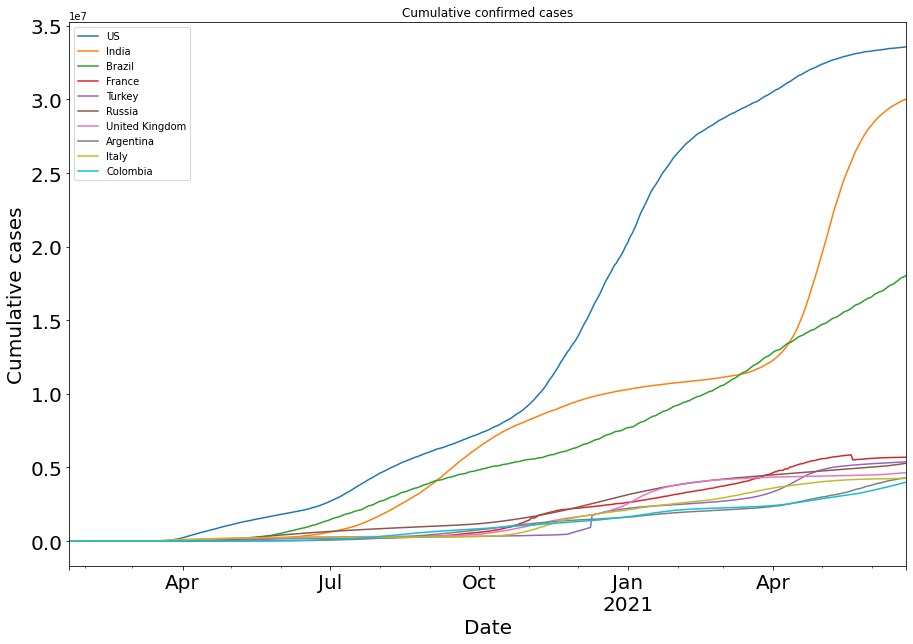

In [42]:
def check_basics(df):
    return df.isna().sum(), df.dtypes
print(" ARE THERE ANY NULL VALUES? WHAT IS THE DATATYPE OF COLUMNS")
print(check_basics(data_use))
# set data into day frequency
data_use = data_use.asfreq("D")
plt.figure(figsize= (15,10))
plt.title("Cumulative confirmed cases")
# plot the reported cumulative confrimed cases of all selected countries.
for i in (data_use.columns):
    data_use[i].plot(fontsize =20)
    plt.legend()
    plt.xlabel("Date", fontsize =20)
    plt.ylabel("Cumulative cases", fontsize = 20)

In [43]:
# Plot the residuals using autocorrelation
"""Check if the Auto-ARIMA selected models have the auto-correlation 
  of the residual of the initial 7 lags are not significantly different from 0"""
def plot_resid_acf(model):
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_acf(model.resid(), lags =20,ax=ax,color ='#1f77b4',linewidth =0.1)
    plt.legend([('Shaded region = 95% CI')], fontsize='12')
    plt.ylabel("Residuals ACF",fontweight='bold', color = 'Black', fontsize='12', horizontalalignment='center')
    plt.xlabel("Lag", color = 'Black', fontsize='12',fontweight ="bold", horizontalalignment='center')
    plt.xticks( fontsize = 12, rotation=0, fontweight ="bold")
    plt.tick_params(axis = "x",colors = "black", direction = "out", length =4, width= 4)
    plt.tick_params(axis = "y",colors = "black", direction = "out", length =4, width= 4)
    plt.yticks( fontsize = 12, fontweight ="bold")
    plt.grid(linestyle=':', linewidth='1', color='black')
    plt.title(col,  fontsize = 12, fontweight ="bold")
    return plt.show()
     
"""The following function plots 60 day forecast obtained from the forecast dataframe
created in the for loop after optimized model selected via auto-arima """

def plot_forecast(dataframe):
    plt.figure(figsize=(10,7))
    plt.plot(dataframe["forecast"], "-", color = "#1f77b4", label = "forecast")
    plt.plot(dataframe["low"],color ="grey", linewidth =0.5,label = "_")
    plt.plot(dataframe["high"],color ="grey", linewidth =0.5,label = "_")
    lower_bound = dataframe["low"]
    upper_bound =dataframe["high"]
    plt.fill_between(dataframe.index, lower_bound, upper_bound, facecolor='grey', alpha=0.5,
                label="95% confidence interval")
    plt.plot(each_col, color = "red", label= 'Actual data')
    plt.title(col,  fontsize = 12, fontweight ="bold")
    plt.legend(loc ="upper left", fontsize = 17)
    plt.xticks( fontsize = 12,fontweight ="bold",rotation = 35)
    plt.yticks( fontsize = 12,fontweight ="bold")
    xx, locs = plt.yticks()
    ll = ['%.0f' % a for a in xx]
    plt.gca().yaxis.set_major_formatter(FixedFormatter(ll))
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    return plt.show()

the country name is US
2020-01-22           1
2020-01-23           1
2020-01-24           2
2020-01-25           2
2020-01-26           5
                ...   
2021-06-18    33529475
2021-06-19    33537995
2021-06-20    33541887
2021-06-21    33554275
2021-06-22    33565215
Freq: D, Name: US, Length: 518, dtype: int64
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=11539.995, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=11465.479, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=11420.665, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=11537.999, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=11418.064, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=11419.944, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=11419.489, Time=0.17 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=11417.527, Time=0.12 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=11420.115, Time=0.15 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept

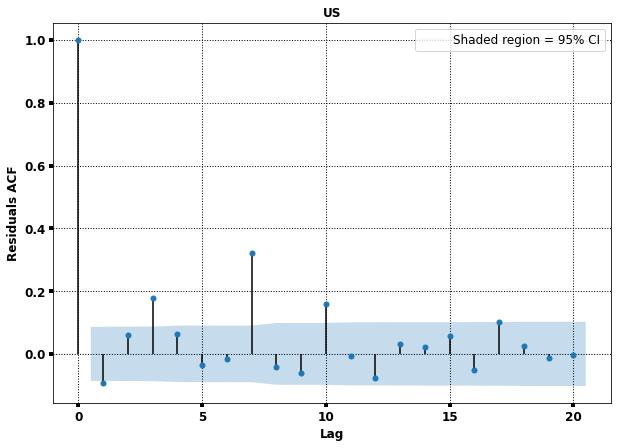

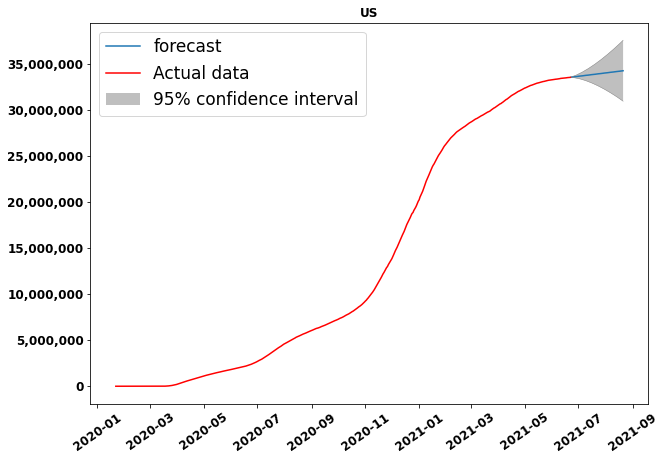

the country name is India
2020-01-22           0
2020-01-23           0
2020-01-24           0
2020-01-25           0
2020-01-26           0
                ...   
2021-06-18    29823546
2021-06-19    29881772
2021-06-20    29935221
2021-06-21    29977861
2021-06-22    30028709
Freq: D, Name: India, Length: 518, dtype: int64
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=10721.809, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=10713.540, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=10712.146, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=10719.895, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=10703.784, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=10704.503, Time=0.17 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=10684.529, Time=0.38 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=10712.204, Time=0.06 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=10673.892, Time=0.21 sec
 ARIMA(3,2,2)(0,0,0)[0] int

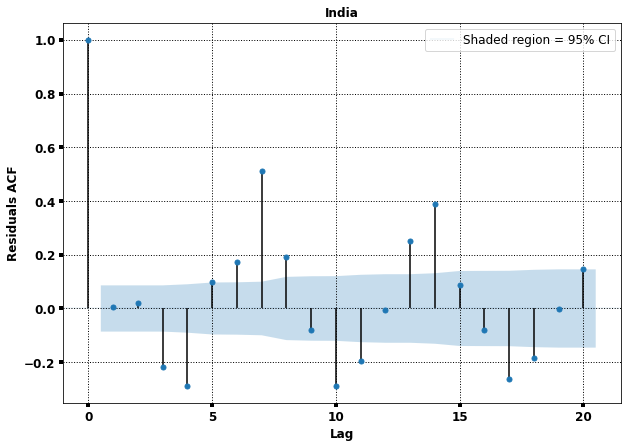

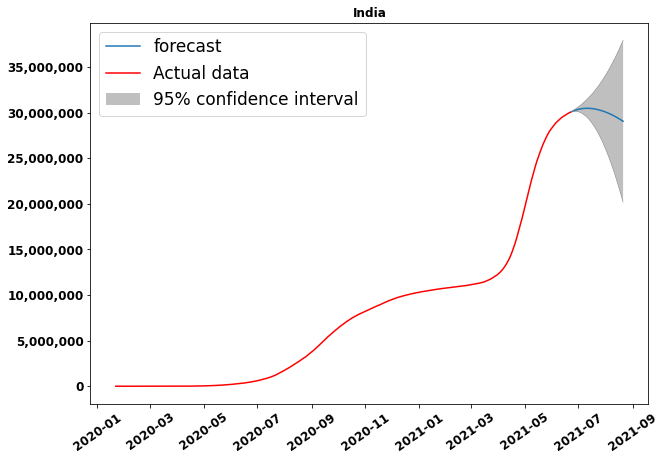

the country name is Brazil
2020-01-22           0
2020-01-23           0
2020-01-24           0
2020-01-25           0
2020-01-26           0
                ...   
2021-06-18    17801462
2021-06-19    17883750
2021-06-20    17927928
2021-06-21    17966831
2021-06-22    18054653
Freq: D, Name: Brazil, Length: 518, dtype: int64
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=11550.830, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=11531.316, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=11422.236, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=11548.883, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=11381.148, Time=0.22 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=11365.076, Time=0.18 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=11507.380, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=11340.955, Time=0.25 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=11484.022, Time=0.09 sec
 ARIMA(4,2,1)(0,0,0)[0] i

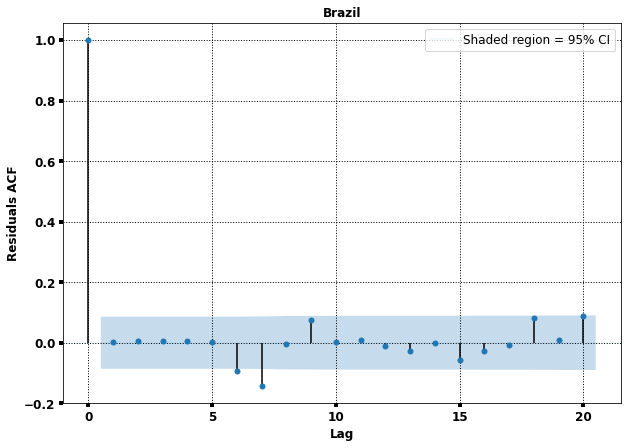

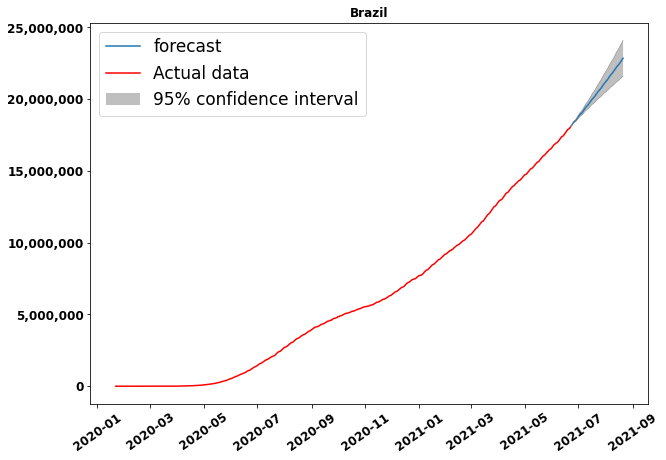

the country name is France
2020-01-22          0
2020-01-23          0
2020-01-24          2
2020-01-25          3
2020-01-26          3
               ...   
2021-06-18    5688557
2021-06-19    5691181
2021-06-20    5692996
2021-06-21    5692968
2021-06-22    5694975
Freq: D, Name: France, Length: 518, dtype: int64
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=12028.670, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=11886.869, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=11698.299, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=12026.674, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=11698.020, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=11695.011, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=11801.960, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=11696.898, Time=0.15 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=11692.690, Time=0.29 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   

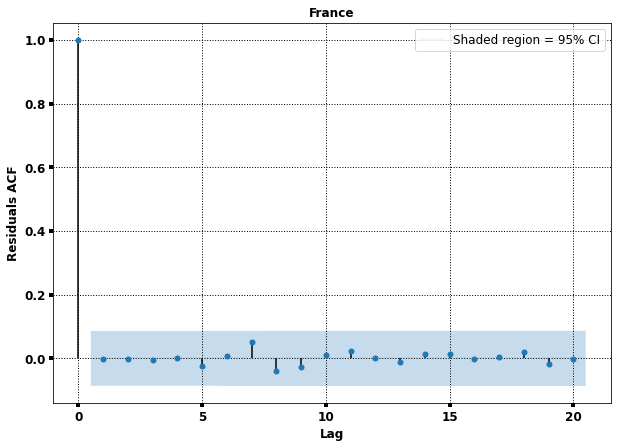

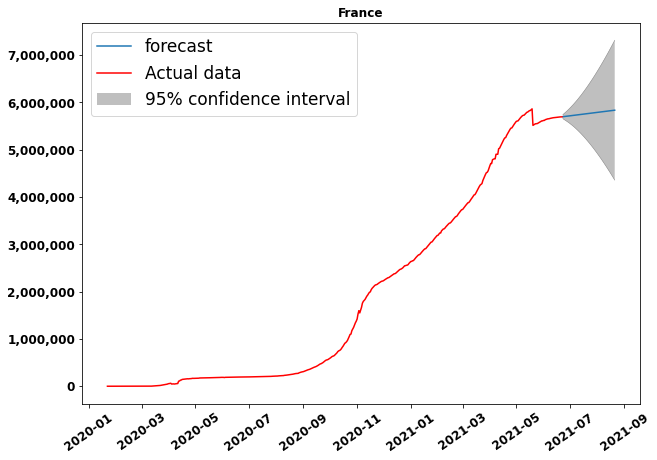

the country name is Turkey
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
               ...   
2021-06-18    5359728
2021-06-19    5365208
2021-06-20    5370299
2021-06-21    5375593
2021-06-22    5381736
Freq: D, Name: Turkey, Length: 518, dtype: int64
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=12619.901, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=12474.877, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=12317.708, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=12617.905, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=12319.691, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=12316.231, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=12317.545, Time=0.08 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=12317.348, Time=0.10 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=12319.094, Time=0.17 sec
 ARIMA(0,2,2)(0,0,0)[0]             

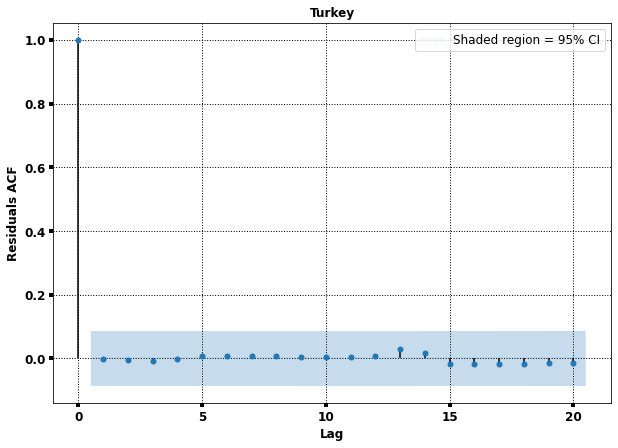

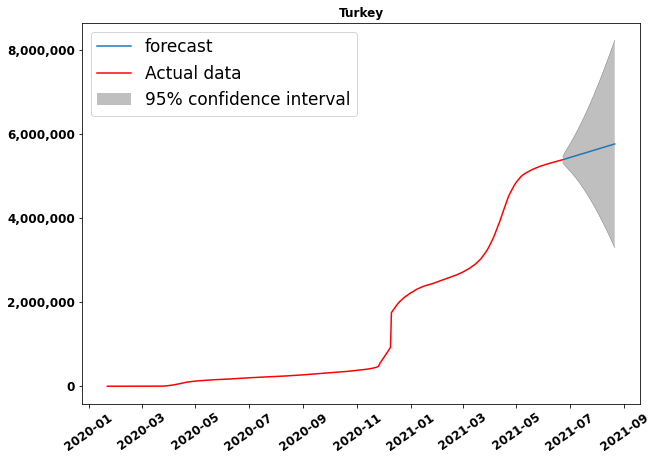

the country name is Russia
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
               ...   
2021-06-18    5220168
2021-06-19    5237847
2021-06-20    5255214
2021-06-21    5272328
2021-06-22    5288766
Freq: D, Name: Russia, Length: 518, dtype: int64
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=8069.442, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=8070.237, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=8070.137, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=8068.900, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=8071.625, Time=0.18 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.343 seconds


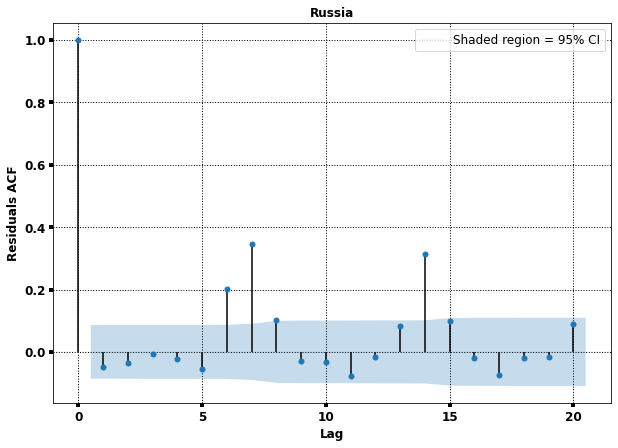

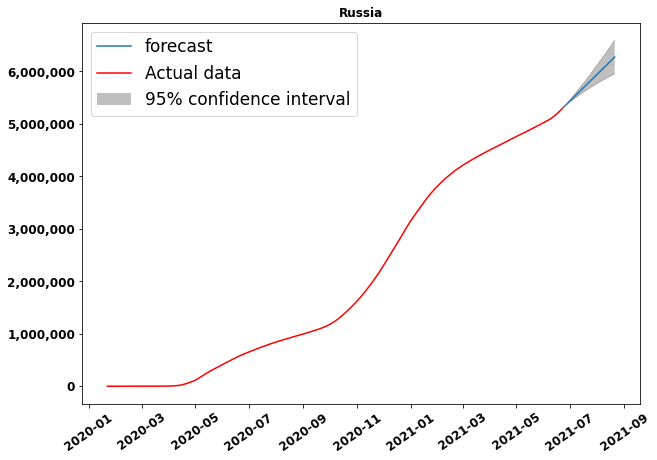

the country name is United Kingdom
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
               ...   
2021-06-18    4610893
2021-06-19    4620968
2021-06-20    4630040
2021-06-21    4640507
2021-06-22    4651988
Freq: D, Name: United Kingdom, Length: 518, dtype: int64
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=9485.040, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=9469.772, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=9467.667, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=9483.089, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=9466.101, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=9468.079, Time=0.15 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=9468.122, Time=0.33 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=9467.537, Time=0.11 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=9470.632, Time=0.06 sec
 ARIMA(2,2,2)(0,0,0)[0] inter

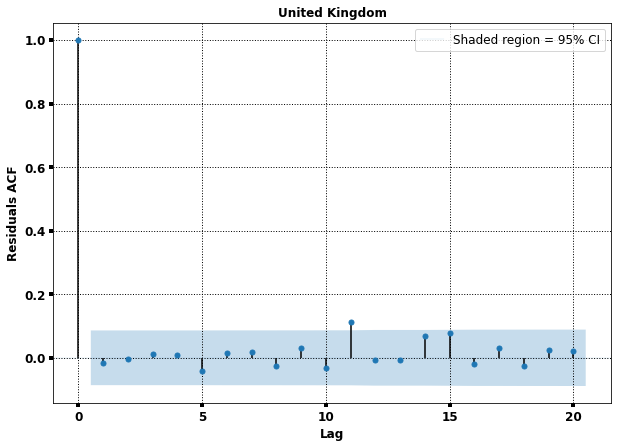

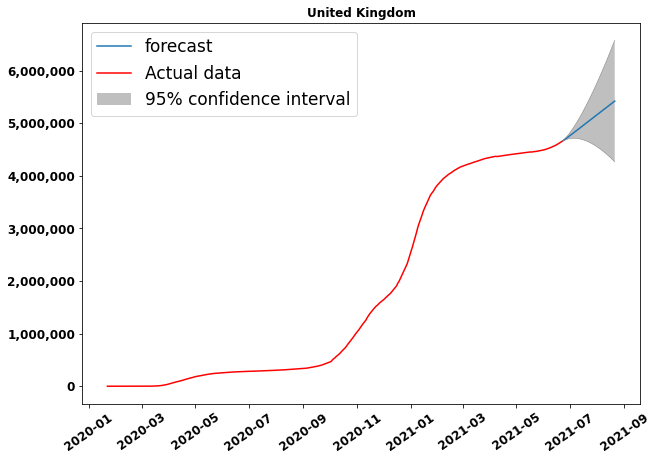

the country name is Argentina
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
               ...   
2021-06-18    4242763
2021-06-19    4258394
2021-06-20    4268789
2021-06-21    4277395
2021-06-22    4298782
Freq: D, Name: Argentina, Length: 518, dtype: int64
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=9617.478, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=9611.108, Time=0.17 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=9601.846, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=9615.604, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=9596.748, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=9457.494, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=9554.262, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=9447.699, Time=0.18 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=9528.881, Time=0.07 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : A

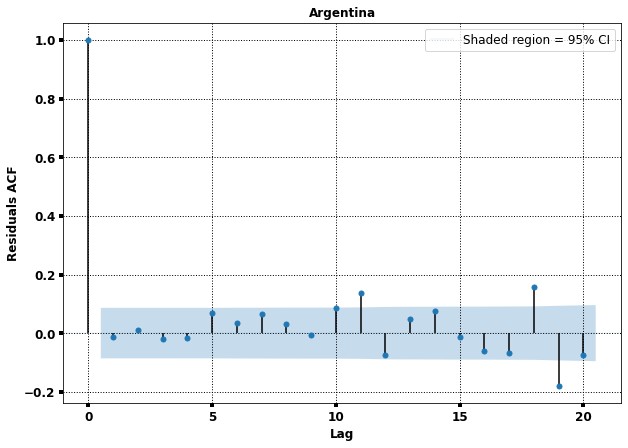

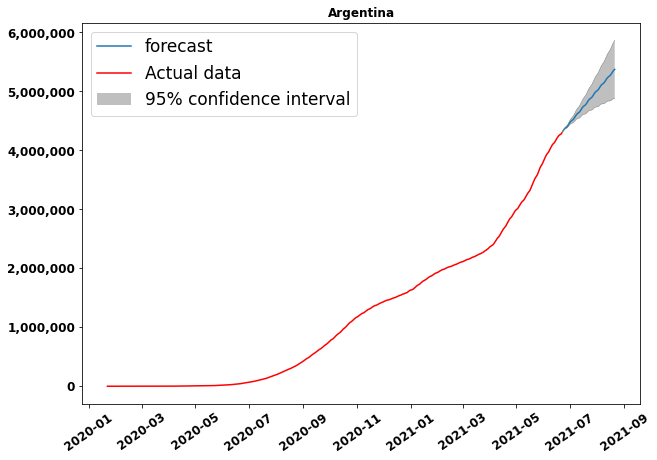

the country name is Italy
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
               ...   
2021-06-18    4250902
2021-06-19    4252095
2021-06-20    4252976
2021-06-21    4253460
2021-06-22    4254294
Freq: D, Name: Italy, Length: 518, dtype: int64
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=9396.439, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=9392.410, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=9389.669, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=9394.444, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=9377.451, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=9307.064, Time=0.16 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=9372.197, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=9278.132, Time=0.21 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=9331.843, Time=0.12 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=9234.

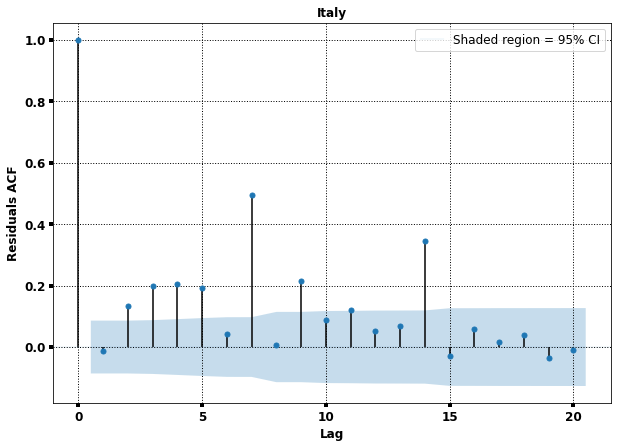

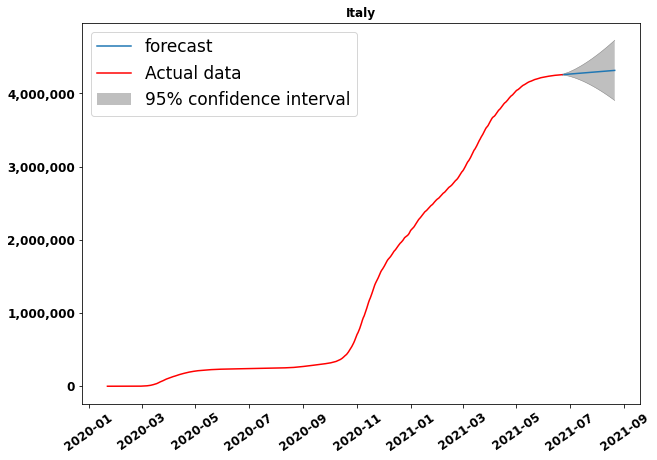

the country name is Colombia
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
               ...   
2021-06-18    3888614
2021-06-19    3917348
2021-06-20    3945166
2021-06-21    3968405
2021-06-22    3997021
Freq: D, Name: Colombia, Length: 518, dtype: int64
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=9013.368, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=9009.409, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=9006.359, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=9012.080, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=8973.118, Time=0.22 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=8964.243, Time=0.28 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=9000.723, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=8955.269, Time=0.19 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=8983.212, Time=0.09 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC

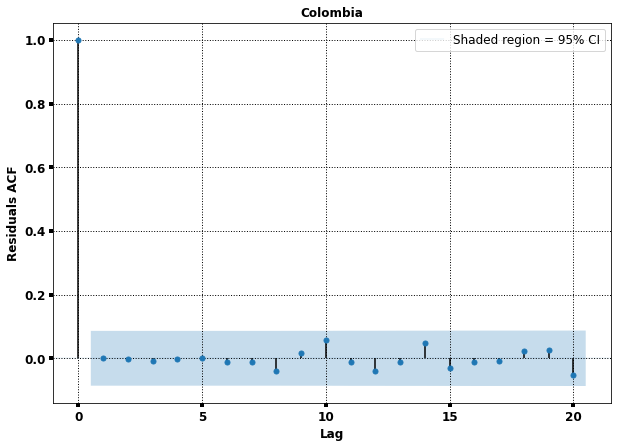

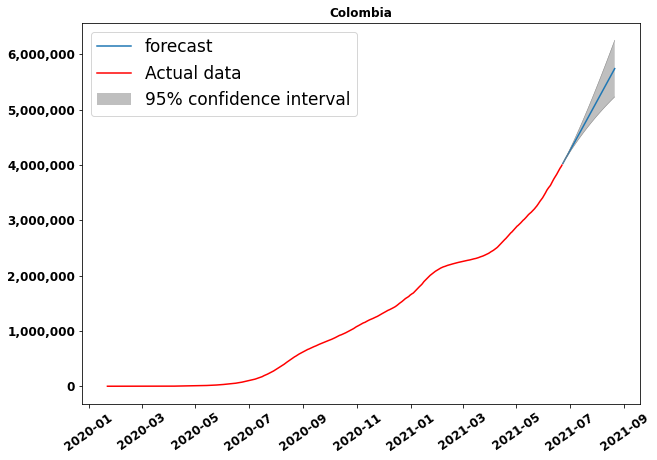

In [44]:
for col in data_use.columns:
    print("the country name is {}".format(col))  
    each_col = data_use[col]
    print(each_col)
    model = auto_arima(each_col, start_p= 0, max_p=10, max_d=2, start_q=0, max_q=10,seasonal=False,
                    trace =True, enforce_stationarity =False, enforce_invertibility =False,
                    error_action ="ignore", suppress_warnings =True,
                    stepwise =True)
    model.summary()
    results = model.fit(each_col)
  # Plot the autocorrelation of residuals using the function
    plot_resid_acf(results)
    forecast,conf_int = results.predict(60,return_conf_int=True,alpha=0.05)
    forecast_df = pd.DataFrame(conf_int,columns=["low","high"])
    forecast_df["forecast"] = forecast
    forecast_df["Date"]= pd.date_range(start = "2021-06-23", end ="2021-08-21", freq = "D")
    forecast_df.set_index("Date", inplace =True)
    plot_forecast(forecast_df)

**Conclusions:**
1. Identified the top 10 countries that are highly impacted by the COVID-19
2. For the selected top 10 countries, arima models were delveoped using auto-arima to forecast the 60 day into the future
3. The similar sudy was extended to recovered cases and deaths to forecast them. A case study on USA was also reported where I discussed the plot diagnostics such as Q-Q plots and KDE plots.
4. For some of the country's data, the residuals are significantly different from zero. which means ARIMA models are linear and could not capture the seasonality or non-linearity that is present in the data. 
5. In detailed report on ARIMA and SARIMA models can be obained here [Applied Soft Computing: Impact factor 6.7](https://www.sciencedirect.com/science/article/abs/pii/S1568494621000843)

6. Complex models such as LSTM-RNN and GRU-RNN are required to better capture the non-linearity. 